### Contexto 

Uma fintech de Crédito iniciou sua operação de concessão de empréstimo pessoal e acompanhou a performance de pagamento de 1.000 clientes após 1 ano. Com base dessa amostra, pediu para a área de Análise de Dados verificar quais os fatores de risco dos clientes de forma a conseguir aprovar mais contratos com a menor inadimplência possível.
Com base nessas informações, pede-se:

Quais fatores de risco estão mais associados a inadimplência? Com isso, o que a fintech deveria mudar de forma a minimizar a inadimplência?
Crie uma forma de atribuir a probabilidade de inadimplência para cada cliente da base usando os fatores de risco identificados.
Discuta um corte nessa probabilidade de forma a aprovar clientes apenas acima do corte. Se isso acontecer, qual a probabilidade de inadimplência esperada e qual a proporção de clientes aprovados esperada?

### Carregamento de pacotes 

In [5]:
import pandas as pd
import numpy as np


# Pacotes gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz
from plotnine import*

# Pacotes de modelagem
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Módulo de Análise Exploratória
import aed
from ydata_profiling import ProfileReport

### Ajuste do banco de dados

In [6]:
#Leitura de dados
df = pd.read_excel("Base_Inadimplencia.xlsx", sheet_name=1)

In [69]:
df.columns
#df.dtypes
#df.isnull().sum()
#df.index.duplicated().sum()
#df.info()

Index(['Idade', 'Sexo', 'Escolaridade', 'Tipo_Moradia', 'Saldo_Investimento',
       'Saldo_Conta_Corrente', 'Valor_Emprestimo', 'Duracao_Emprestimo',
       'Inadimplencia'],
      dtype='object')

### Analise exploratoria

###### ANALISE EXPLORATÓRIA RESUMO:

A partir do relatório gerado observamos inicialmente uma alta correlação das variáveis "duração do empréstimo" e "valor do empréstimo". trazendo a informação que, para adiante, quando formos fazer a análise de regressão logística optemos por uma ou por outra variável para não ocasionar multicolinearidade.

Logo após podemos ver um valor de information value (IV) significativo entre as categorias da variável "saldo em conta corrente" sendo a mais significativa: 'sem conta' seguido de 'pouco'. a variável 'saldo investimento' também possui nível de IV significativo. (isso que dizer que os grupos dessa variável não são homogêneos em relação a variável inadimplência? )

#### Relatorio Profile Report

In [86]:
Relatorio = ProfileReport(df, title="Relatório Inadimplência")
Relatorio

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Analise IV

In [3]:
df_iv = aed.analise_iv(df,'Inadimplencia')
df_iv.get_lista_iv()

C:\Users\tania\Desktop\Git-Hub\Financial_Technology\Financial_Technology\aed.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Inadimplencia,IV
Variavel,
Saldo_Conta_Corrente,0.73
Duracao_Emprestimo,0.25
Saldo_Investimento,0.20
Valor_Emprestimo,0.11
Idade,0.09
Tipo_Moradia,0.09
Sexo,0.03
Escolaridade,0.01


In [4]:
df_iv.get_bivariada(var_escolhida='Saldo_Conta_Corrente')

==> "Saldo_Conta_Corrente" tem IV de 0.73


Inadimplencia,Variavel,Var_Range,#Target_1,#Target_0,Total,%Freq,%Target_1,%Target_0,%Taxa_de_Target_1,Odds,LN(Odds),IV
0,Saldo_Conta_Corrente,Alto,21,87,108,10.8,7.00,12.43,19.44,0.56,-0.58,0.03
1,Saldo_Conta_Corrente,Moderado,98,126,224,22.4,32.67,18.00,43.75,1.82,0.60,0.09
2,Saldo_Conta_Corrente,Pouco,135,139,274,27.4,45.00,19.86,49.27,2.27,0.82,0.21
3,Saldo_Conta_Corrente,Sem conta,46,348,394,39.4,15.33,49.71,11.68,0.31,-1.17,0.40


In [7]:
df_iv.get_bivariada(var_escolhida='Saldo_Investimento')

==> "Saldo_Investimento" tem IV de 0.2


Inadimplencia,Variavel,Var_Range,#Target_1,#Target_0,Total,%Freq,%Target_1,%Target_0,%Taxa_de_Target_1,Odds,LN(Odds),IV
0,Saldo_Investimento,Alto,17,94,111,11.1,5.67,13.43,15.32,0.42,-0.87,0.07
1,Saldo_Investimento,Moderado,34,69,103,10.3,11.33,9.86,33.01,1.15,0.14,0.00
2,Saldo_Investimento,Pouco,217,386,603,60.3,72.33,55.14,35.99,1.31,0.27,0.05
3,Saldo_Investimento,Sem investimento,32,151,183,18.3,10.67,21.57,17.49,0.49,-0.71,0.08


#### Box plot Inadimplencia VS valor_Emprestimo / Duracao_Emprestimo 

<Axes: xlabel='Inadimplencia', ylabel='Valor_Emprestimo'>

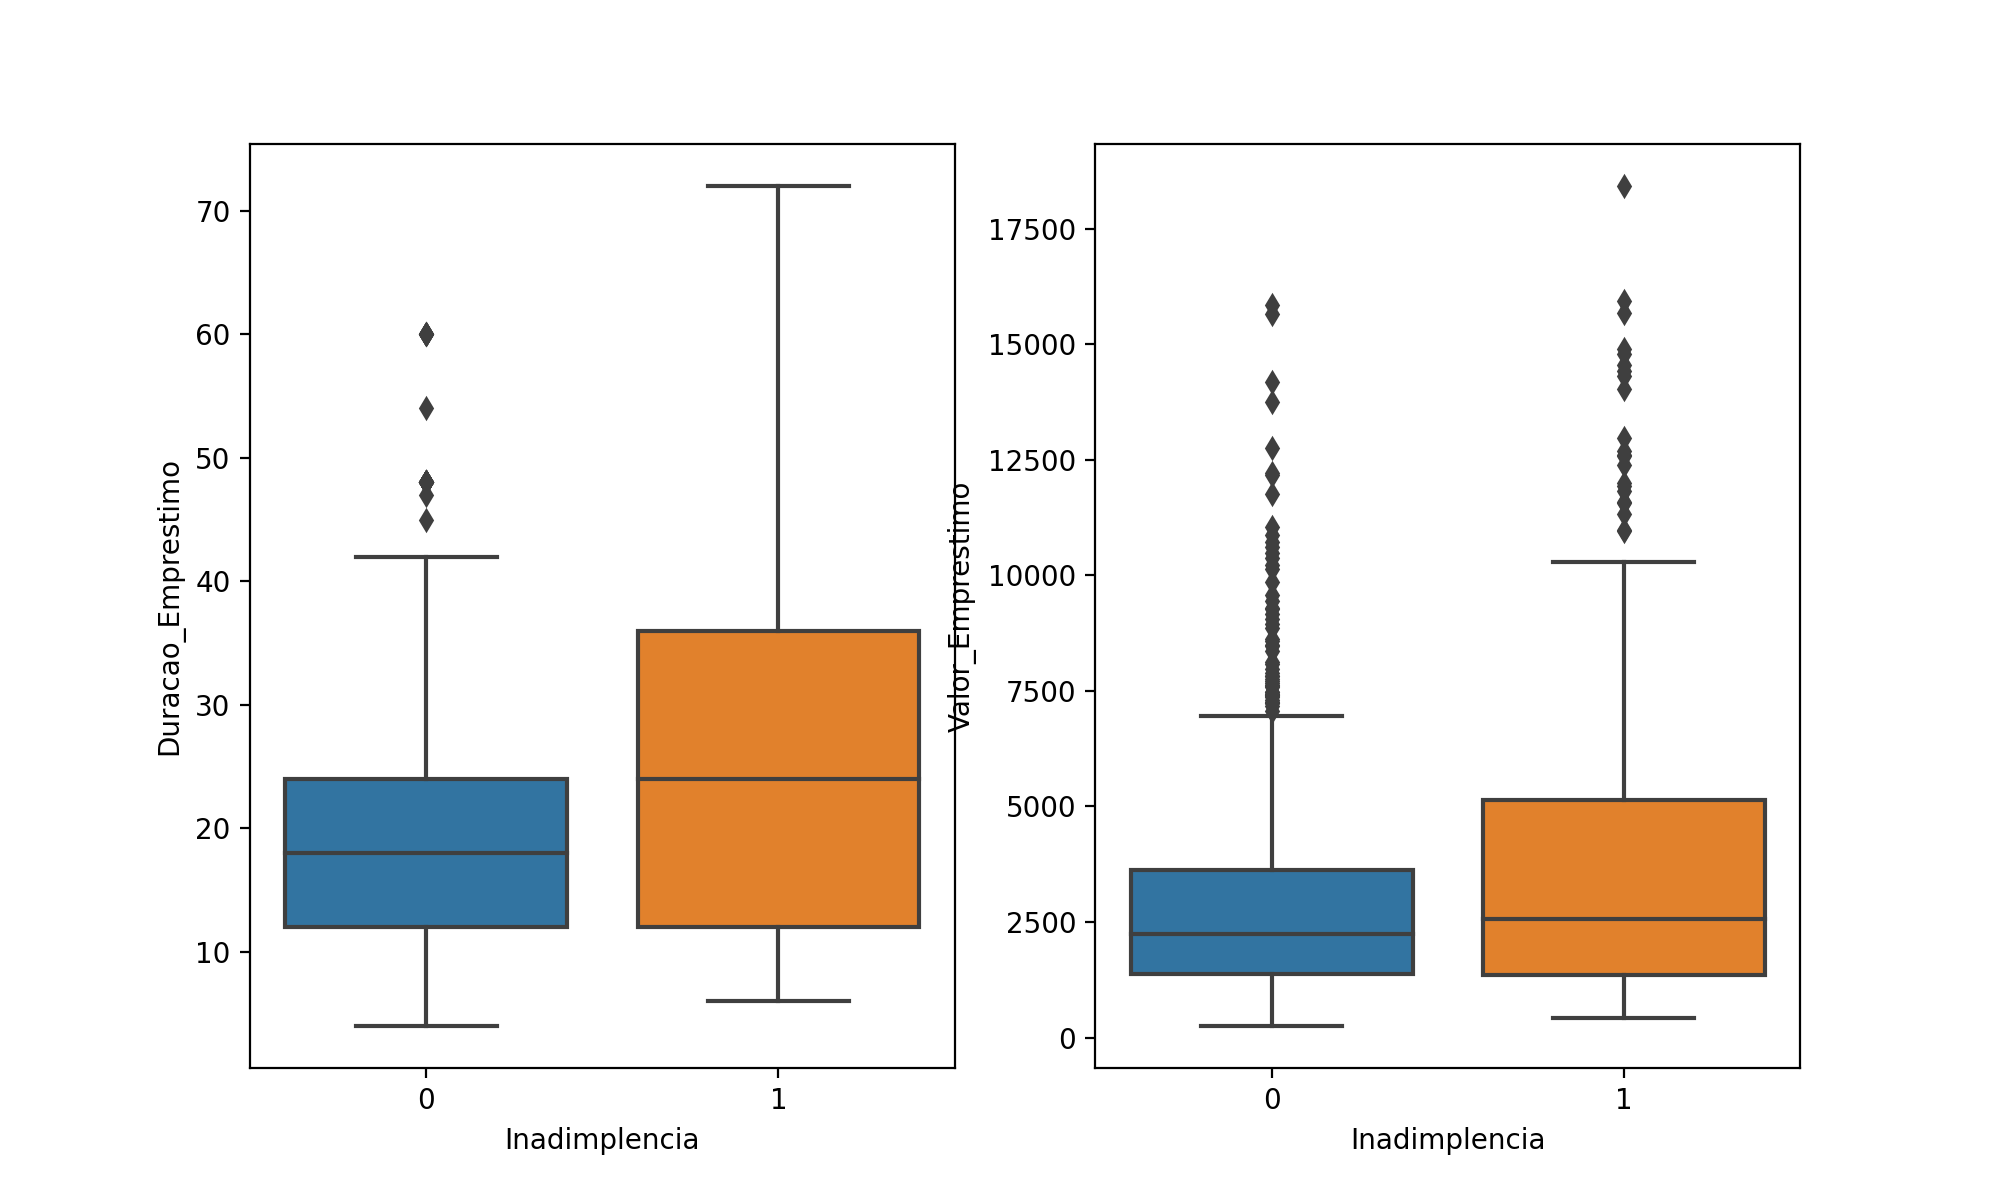

In [40]:

plt.figure(figsize=(10, 6))  # Define o tamanho da figura

plt.subplot(1, 2, 1)  # Cria o primeiro subplot para a variável 
sns.boxplot(x='Inadimplencia', y='Duracao_Emprestimo', data=df)

plt.subplot(1, 2, 2)  # Cria o segundo subplot para a variável 
sns.boxplot(x='Inadimplencia', y='Valor_Emprestimo', data=df)


### Criação do modelo de Arvore de decisão

##### INTERPRETAÇÃO DO MODELO DE ARVORE DE DECISÃO:

As características da pessoa inadimplente segundo a arvore de decisão gerada é: 
pessoas que possuem valor em conta corrente que não é 'alto' e que a duração do empréstimo é maior que 22.5 meses.  



Da arvore de decisão gerada obtemos uma acurácia de 0.75 significando um bom ajuste no modelo. (ter cuidado para ver se a base de dados é balanceada. (no caso está)) (a acurácia em arvores de decisão não são precisas com a base desbalanceada? ou seria somente em casos de modelo de regressão logístico?) (que tipo de análise seria feito para bases desbalanceadas) 

In [14]:
# Criação das variáveis dummies
df_modelo_a = pd.get_dummies(df)
df_modelo_a.head()

,Idade,Valor_Emprestimo,Duracao_Emprestimo,Inadimplencia,Sexo_H,Sexo_M,Escolaridade_Ensino Medio,Escolaridade_Graduacao,Escolaridade_Pos Graduacao,Tipo_Moradia_Alugada,Tipo_Moradia_De favor,Tipo_Moradia_Propria,Saldo_Investimento_Alto,Saldo_Investimento_Moderado,Saldo_Investimento_Pouco,Saldo_Investimento_Sem investimento,Saldo_Conta_Corrente_Alto,Saldo_Conta_Corrente_Moderado,Saldo_Conta_Corrente_Pouco,Saldo_Conta_Corrente_Sem conta
0,67,1169,6,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0
1,22,5951,48,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0
2,49,2096,12,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
3,45,7882,42,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0
4,53,4870,24,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0


In [15]:
# Target (variável resposta)
y = df_modelo_a['Inadimplencia']

# Features (variáveis explicativas)
x = df_modelo_a.drop(['Inadimplencia'], 
                      axis = 1)

In [16]:
modelo_Inadimplencia = DecisionTreeClassifier(max_depth=3, 
                                         random_state=35)
modelo_Inadimplencia.fit(x, y)

DecisionTreeClassifier(max_depth=3, random_state=42)

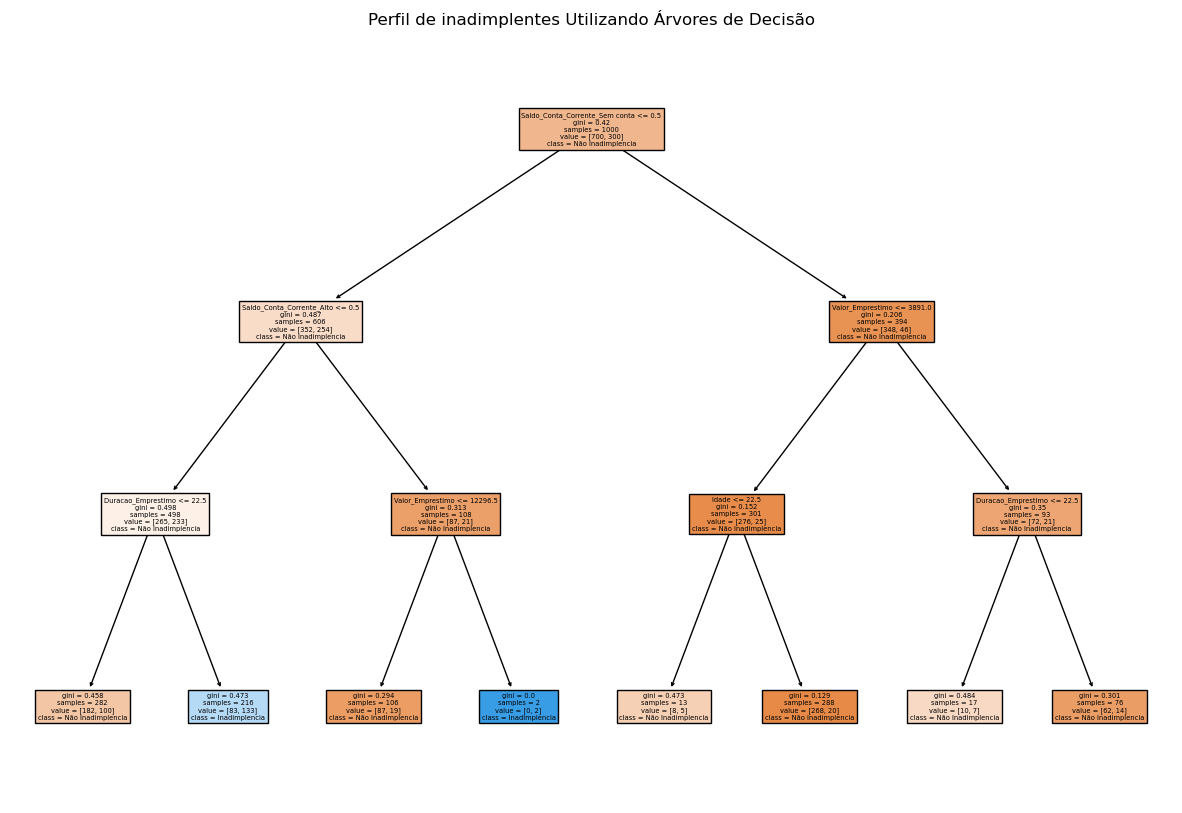

In [17]:

sns.reset_defaults()
%matplotlib inline
fig = plt.figure(figsize=(15,10))
features = list(x.columns)
tree.plot_tree(modelo_Inadimplencia,
               feature_names=features, 
               class_names=['Não Inadimplencia','Inadimplencia'],
               filled=True);
plt.title("Perfil de inadimplentes Utilizando Árvores de Decisão");

In [41]:
# Cálculo do desempenho do modelo: Acurácia
round(accuracy_score(y, modelo_Inadimplencia.predict(x)),2)

0.75

### Regressão Logistica para atribuição do score 

##### INTERPRETAÇÃO DA REGRESSÃO LOGISTICA:
A partir do modelo logístico de regressão gerada pelo 'statsmodels' apodemos observar que as variáveis mais relacionadas com a inadimplência são: 

idade, reduzindo a cada ano 2% a chance de ser inadimplente.
duração empréstimo, aumentando, a cada mês, em 3% a chance de ser inadimplente.
sexo 'mulher', diminuindo em 32% a chance de ser inadimplente.
escolaridade 'graduação', diminui em 29% a chance de ser inadimplente.
tipo de moradia 'própria', diminui em 32% a chance de ser inadimplente
saldo em conta corrente 'moderado', aumenta em 62% a chance  de ser inadimplente
saldo em conta corrente 'pouco', aumenta em 122% a chance de ser inadimplente
saldo em conta corrente 'sem conta corrente', diminui em 65% a chance de ser inadimplente


O pseudo r2 do modelo feito pelo 'statsmodels' deu uma valor de 0,16. significa que o modelo explica uma parcela relativamente pequena da variabilidade dos dados.  (mas isso não implica automaticamente em uma má capacidade de previsão.)

Já para a o modelo logístico para classificação realizado com o 'sklearn' possuiu uma performance melhor, com uma precisão de 0,57 e um recall de 0,35. em seguido foi criada uma variável chamada 'probabilidade inadimplência' para cada cliente e anexada ao no banco de dados.

##### NOTA: 
Com que insights criar um corte na probabilidade? e como calcular a inadimplência esperada e a quantidade de clientes aprovados?

In [53]:
#Separeando variaveis resposta e criando variaveis dummies 
y= df['Inadimplencia']

df.drop(columns=['Inadimplencia' ], inplace=True)

#Para analise de regressao logistica é necessario excluir a primeira classe de dummies
df_modelo_l = pd.get_dummies(df, drop_first=True) 
df_modelo_l

,Idade,Valor_Emprestimo,Duracao_Emprestimo,Sexo_M,Escolaridade_Graduacao,Escolaridade_Pos Graduacao,Tipo_Moradia_De favor,Tipo_Moradia_Propria,Saldo_Investimento_Moderado,Saldo_Investimento_Pouco,Saldo_Investimento_Sem investimento,Saldo_Conta_Corrente_Moderado,Saldo_Conta_Corrente_Pouco,Saldo_Conta_Corrente_Sem conta
0,67,1169,6,1,1,0,0,1,0,0,1,0,1,0
1,22,5951,48,0,1,0,0,1,0,1,0,1,0,0
2,49,2096,12,1,0,1,0,1,0,1,0,0,0,1
3,45,7882,42,1,1,0,1,0,0,1,0,0,1,0
4,53,4870,24,1,1,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,1736,12,0,0,1,0,1,0,1,0,0,0,1
996,40,3857,30,1,0,0,0,1,0,1,0,0,1,0
997,38,804,12,1,1,0,0,1,0,1,0,0,0,1
998,23,1845,45,1,1,0,1,0,0,1,0,0,1,0


#### NOTA:
Note que na saída do 'resultado.summary' não temos uma categoria de cada variável por conta do drop_first. como faço para analisar essa categoria?  

#### Modelo por statsmodel

In [4]:
#Criando o modelo de regressão logística usando statsmodels para analise dos coeficientes 
import statsmodels.api as sm

modelo2 = sm.Logit(y, df_modelo_l)
resultado = modelo2.fit()

# Imprimir a saída detalhada
print(resultado.summary())



Optimization terminated successfully.
         Current function value: 0.511423
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          Inadimplencia   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      986
Method:                           MLE   Df Model:                           13
Date:                Sat, 02 Sep 2023   Pseudo R-squ.:                  0.1628
Time:                        12:03:55   Log-Likelihood:                -511.42
converged:                       True   LL-Null:                       -610.86
Covariance Type:            nonrobust   LLR p-value:                 2.319e-35
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Idade                                  -0.0250      0.007 

In [71]:
probabilidades_previstas = resultado.predict(df_modelo_l)

# As probabilidades_previstas agora contêm as probabilidades previstas para cada indivíduo
print(probabilidades_previstas)

0      0.097285
1      0.726226
2      0.057080
3      0.660508
4      0.462866
         ...   
995    0.123578
996    0.542541
997    0.070759
998    0.762111
999    0.550461
Length: 1000, dtype: float64


In [8]:
#excluindo uma das variaveis 'valor emprestimo' ou "duração emprestimo"
df.drop(columns=['Valor_Emprestimo'], inplace=True)

#Para analise de regressao logistica é necessario excluir a primeira classe de dummies
df_modelo_l2 = pd.get_dummies(df, drop_first=True) 

#Criando o modelo de regressão logística usando statsmodels para analise dos coeficientes sem a variavel que ocasiona mmulticolinearidade
modelo2_2 = sm.Logit(y, df_modelo_l2)
resultado2 = modelo2_2.fit()

# Imprimir a saída detalhada
print(resultado2.summary())

Optimization terminated successfully.
         Current function value: 0.511653
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          Inadimplencia   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      987
Method:                           MLE   Df Model:                           12
Date:                Sat, 02 Sep 2023   Pseudo R-squ.:                  0.1624
Time:                        12:10:44   Log-Likelihood:                -511.65
converged:                       True   LL-Null:                       -610.86
Covariance Type:            nonrobust   LLR p-value:                 6.902e-36
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Idade                                  -0.0248      0.007 

In [52]:
print("Idade:", 1- np.exp(-0.0248))
print("Duracao_Emprestmo:", np.exp(0.0335))
print("Sexo_M:", 1-np.exp(-0.3975))
print("Escolaridade_Graduacao:", 1- np.exp(-0.3506))
print("Tipo_Moradia_Propria:", 1- np.exp(-0.4523))
print("Saldo_Conta_Corrente_Moderado:", np.exp(0.4880))
print("Saldo_Conta_Corrente_Pouco:", np.exp(0.7994))
print("Saldo_Conta_Corrente_Sem conta:", 1- np.exp(-1.0578))

Idade: 0.02449500648176295
Duracao_Emprestmo: 1.0340674437262785
Sexo_M: 0.32800205735241106
Escolaridade_Graduacao: 0.2957345963166266
Tipo_Moradia_Propria: 0.36383670789275624
Saldo_Conta_Corrente_Moderado: 1.6290548499725743
Saldo_Conta_Corrente_Pouco: 2.2242060044526317
Saldo_Conta_Corrente_Sem conta: 0.6527811478489736


#### Modelo por sklearn

In [55]:
#Criando modelo de regressão logistica usando scikit-learn para analise preditiva
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Dividir o conjunto de dados em treinamento e teste
dados_train, dados_test, y_train, y_test = train_test_split(df_modelo_l, y, test_size=0.3, random_state=42)

In [56]:

#Escalar os dados
scaler = StandardScaler()
dados_train_scaled = scaler.fit_transform(dados_train)
dados_test_scaled = scaler.transform(dados_test)

#Criar e treinar o modelo de regressão logística com o solver 'liblinear'
modelo1 = LogisticRegression(solver='liblinear', random_state=42)
modelo1.fit(dados_train_scaled, y_train)

#Realizar previsões no conjunto de teste
y_pred = modelo1.predict(dados_test_scaled)


In [67]:
y_pred

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1], d

#### Medidas de performance do modelo

In [57]:
#Metricas para o modelo de regressão logística com o solver 'liblinear'
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, average_precision_score

#Calcular a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo:", accuracy)

# Calcular a precisão do modelo
precision = precision_score(y_test, y_pred)
print("Precisão do modelo:", precision)

# Calcular o recall (sensibilidade) do modelo
recall = recall_score(y_test, y_pred)
print("Recall do modelo:", recall)

# Calcular o F1-score do modelo
f1 = f1_score(y_test, y_pred)
print("F1-score do modelo:", f1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusão:")

print(conf_matrix)

auc_roc = roc_auc_score(y_test, y_pred)
print("AUC-ROC:", auc_roc)

# Calcular o AUC-PR
auc_pr = average_precision_score(y_test, y_pred)
print("AUC-PR:", auc_pr)


Acurácia do modelo: 0.7233333333333334
Precisão do modelo: 0.5769230769230769
Recall do modelo: 0.32967032967032966
F1-score do modelo: 0.4195804195804196
Matriz de confusão:
[[187  22]
 [ 61  30]]
AUC-ROC: 0.6122035858877963
AUC-PR: 0.39352775429698506


#### Probabilidade dos colaboradores se tornarem inadimplente (SCORE) 

In [81]:
#Apartir do modelo de regressao logistico statsmodel
dados_teste_com_prob = df.copy()
dados_teste_com_prob['Probabilidades_previstas'] = probabilidades_previstas 

# Formatando as probabilidades para saírem com no máximo 5 casas decimais
dados_teste_com_prob['Probabilidades_previstas'] = dados_teste_com_prob['Probabilidades_previstas'].apply(lambda x: format(x, '.5f'))
dados_teste_com_prob['Probabilidades_previstas'] = dados_teste_com_prob['Probabilidades_previstas'].astype(float)


In [78]:
dados_teste_com_prob

,Idade,Sexo,Escolaridade,Tipo_Moradia,Saldo_Investimento,Saldo_Conta_Corrente,Valor_Emprestimo,Duracao_Emprestimo,Inadimplencia,Probabilidades_previstas
0,67,M,Graduacao,Propria,Sem investimento,Pouco,1169,6,0,0.09728
1,22,H,Graduacao,Propria,Pouco,Moderado,5951,48,1,0.72623
2,49,M,Pos Graduacao,Propria,Pouco,Sem conta,2096,12,0,0.05708
3,45,M,Graduacao,De favor,Pouco,Pouco,7882,42,0,0.66051
4,53,M,Graduacao,De favor,Pouco,Pouco,4870,24,1,0.46287
...,...,...,...,...,...,...,...,...,...,...
995,31,H,Pos Graduacao,Propria,Pouco,Sem conta,1736,12,0,0.12358
996,40,M,Ensino Medio,Propria,Pouco,Pouco,3857,30,0,0.54254
997,38,M,Graduacao,Propria,Pouco,Sem conta,804,12,0,0.07076
998,23,M,Graduacao,De favor,Pouco,Pouco,1845,45,1,0.76211


In [84]:
# Filtrar o DataFrame para as observações que atendem aos critérios
observacoes_filtradas = dados_teste_com_prob[(dados_teste_com_prob['Inadimplencia'] == 1) & (dados_teste_com_prob['Probabilidades_previstas'] < 0.4)]

# Contar o número de observações no DataFrame filtrado
numero_observacoes = len(observacoes_filtradas)

# Imprimir o número de observações que atendem aos critérios
print("Número de observações com Inadimplência = 1 e Probabilidade_prevista < 0.4:", numero_observacoes)

Número de observações com Inadimplência = 1 e Probabilidade_prevista < 0.4: 123


#### NOTA:

Pensei em, através da regressão logística, atribuir uma probabilidade entre 0 e 1 para cada pessoa na base de dados. traçar um corte na probabilidade 0.4 onde acima disso seria considerado inadimplente. assim teríamos uma inadimplência esperada com as pessoas que foram inadimplentes abaixo de 0.4? 

Ao realizar essa etapa verificamos que 123 observações que não eram consideradas pelo modelo como possível inadimplente, foram inadimplentes o que significa que não foi uma boa analise?


#### Salvando os scores em um novo banco de dados 

In [63]:
# Ordenando o DataFrame pelas probabilidades de Prob_Inadimplencia em ordem decrescente
dados_teste_com_prob = dados_teste_com_prob.sort_values(by='Prob_Inadimplencia', ascending=False)

dados_teste_com_prob.to_csv("dados_teste_com_prob.csv ")


#### NOTA: 

##### PARA FUTURAS ANALISES USAR NA ARVORE DE DECISÃO: 
viz = dtreeviz(tree_model=modelo_Inadimplencia,
               x_data=x, y_data=y, 
               target_name='Target',
               feature_names=features,
               class_names=['Não Inadimplencia', 'Inadimplencia'], 
               scale=2.0)
viz

In [ ]:
# Removendo os outliers do dataset de treino
#df_train.drop(df_train[(df_train.Product_Category_1 == 19) | (df_train.Product_Category_1 == 20)].index,inplace=True)

### CONCLUSÃO

O que a empresa deve fazer a partir da análise feita?\
Realizar um acompanhamento de perto dos clientes que já possuem empréstimo com conta corrente pouca e média com parcelas maiores de 22 meses. e ofertar empréstimo com foco em clientes mulheres, que possuam escolaridade graduação e que possuem uma conta corrente alta.  
